In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [234]:
path = "C:/Users/kosma/OneDrive/Desktop/FER/Uzop/"
df = pd.read_csv(path + "march-machine-learning-mania-2015/regular_season_detailed_results.csv", sep = ",")

In [235]:
def calculate_rpi(df):
  # Calculate winning percentage for each team
  wins = df['wteam'].value_counts()
  losses = df['lteam'].value_counts()
  games_played = wins.add(losses, fill_value=0)
  wp = wins / games_played

  # Calculate opponents winning percentage
  opponents_wps = pd.concat([df.groupby('wteam')['lteam'].apply(lambda x: wp[x].mean()),
                 df.groupby('lteam')['wteam'].apply(lambda x: wp[x].mean())])
  owp = opponents_wps.groupby(opponents_wps.index).mean()

  # Calculate opponents opponents winning percentage
  opponents_owps = pd.concat([df.groupby('wteam')['lteam'].apply(lambda x: owp[x].mean()),
                df.groupby('lteam')['wteam'].apply(lambda x: owp[x].mean())])
  oowp = opponents_owps.groupby(opponents_owps.index).mean()

  # Calculate RPI
  rpi = (wp * 0.25) + (owp * 0.50) + (oowp * 0.25)
  return rpi

In [236]:
# Function to calculate probability of winning

def predictWin(D_prime, V_prime):
    # Define the response variable and predictor variables
    X = D_prime[V_prime]
    
    # Determine the team with the higher RPI
    winner_team = np.where(D_prime['rpi_wteam'] > D_prime['rpi_lteam'], D_prime['wteam'], D_prime['lteam'])
    winning_rpi = np.where(D_prime['rpi_wteam'] > D_prime['rpi_lteam'], D_prime['rpi_wteam'], D_prime['rpi_lteam'])

    # Create a DataFrame with the IDs, winner team, and the RPI of the winning team
    results = pd.DataFrame({
        'id': D_prime['season'].astype(str) + '_' + D_prime['wteam'].astype(str) + '_' + D_prime['lteam'].astype(str),
        'winner_team': winner_team,
        'winning_rpi': winning_rpi
    })

    return results


In [237]:
# Convert columns to numeric data types
df['wteam'] = pd.to_numeric(df['wteam'], errors='coerce')
df['lteam'] = pd.to_numeric(df['lteam'], errors='coerce')

# Calculate RPI for each team
rpi = calculate_rpi(df)

# Add the calculated RPIs to the dataset
df['rpi_wteam'] = df['wteam'].map(rpi)
df['rpi_lteam'] = df['lteam'].map(rpi)

# Convert RPI columns to numeric data types
df['rpi_wteam'] = pd.to_numeric(df['rpi_wteam'], errors='coerce')
df['rpi_lteam'] = pd.to_numeric(df['rpi_lteam'], errors='coerce')

df['wloc'] = pd.to_numeric(df['wloc'], errors='coerce')

# Call predictWin function
P = predictWin(df, df.keys())

print(P)
print(P.iloc[0])

                   id  winner_team  winning_rpi
0      2003_1104_1328         1328     0.591459
1      2003_1272_1393         1393     0.637194
2      2003_1266_1437         1437     0.604826
3      2003_1296_1457         1457     0.492299
4      2003_1400_1208         1400     0.616606
...               ...          ...          ...
60513  2014_1196_1246         1246     0.627319
60514  2014_1277_1276         1277     0.615733
60515  2014_1386_1433         1433     0.570856
60516  2014_1418_1209         1418     0.494806
60517  2014_1438_1181         1181     0.648639

[60518 rows x 3 columns]
id             2003_1104_1328
winner_team              1328
winning_rpi          0.591459
Name: 0, dtype: object


In [238]:
def calculateAccuracy(D_prime, results):
    # Calculate accuracy
    actual_winner_id = D_prime['season'].astype(str) + '_' + D_prime['wteam'].astype(str) + '_' + D_prime['lteam'].astype(str)
    predicted_winner_id = D_prime['season'].astype(str) + '_' + results['winner_team'].astype(str) + '_' + D_prime['lteam'].astype(str)
    
    correct_predictions = np.sum(actual_winner_id == predicted_winner_id)
    total_predictions = len(D_prime)
    accuracy = correct_predictions / total_predictions

    print(f'Accuracy: {accuracy:.2%} ({correct_predictions}/{total_predictions} correct predictions)')

calculateAccuracy(df, P)


Accuracy: 68.13% (41228/60518 correct predictions)


In [239]:
import pandas as pd

def calculate_expected_win_probability(rating_a, rating_b):
    """Calculate the expected win probability of team A against team B."""
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

def update_elo_ratings(rating_a, rating_b, outcome, k=32):
    """
    Update Elo ratings based on the outcome of a game.

    Parameters:
    - rating_a: Elo rating of team A
    - rating_b: Elo rating of team B
    - outcome: 1 for team A win, 0 for team B win
    - k: K-factor, a constant determining the impact of each game (default is 32)

    Returns updated Elo ratings for teams A and B.
    """
    expected_win_probability = calculate_expected_win_probability(rating_a, rating_b)
    rating_a_new = rating_a + k * (outcome - expected_win_probability)
    rating_b_new = rating_b + k * ((1 - outcome) - (1 - expected_win_probability))
    return rating_a_new, rating_b_new

def calculate_final_elo_ratings(game_results, k=32, initial_rating=1500):
    """Calculate final Elo ratings for all teams based on game results."""
    teams = set(game_results['w_team']).union(set(game_results['l_team']))
    elo_ratings = {team: initial_rating for team in teams}

    for index, row in game_results.iterrows():
        w_team = row['w_team']
        l_team = row['l_team']

        # Assuming 1 for w_team win, 0 for l_team win
        outcome = 1  

        elo_ratings[w_team], elo_ratings[l_team] = update_elo_ratings(elo_ratings[w_team], elo_ratings[l_team], outcome, k)

    return elo_ratings

# Updated DataFrame with columns 'w_team' and 'l_team'
game_results = pd.DataFrame({
    'w_team': df['wteam'].astype(int),
    'l_team': df['lteam'].astype(int)
})

# Calculate final Elo ratings for all teams
elo_ratings = calculate_final_elo_ratings(game_results)

# Display final Elo ratings
print("Team       ELO")
for team, rating in elo_ratings.items():
    print(f"{team}: {rating}")


Team       ELO
1101: 1262.146946797808
1102: 1509.0582120180031
1103: 1659.2925203190025
1104: 1697.3840773847405
1105: 1133.74681075104
1106: 1203.8485434683396
1107: 1449.1720248477066
1108: 1073.6355989970007
1110: 1463.016564888808
1111: 1221.054420291547
1112: 1982.8757576178973
1113: 1760.3838113079794
1114: 1414.539831862339
1115: 1210.8773476219674
1116: 1784.7605723088257
1117: 1477.0985307687583
1119: 1377.185083258186
1120: 1589.373906406084
1122: 1222.2841952001097
1123: 1267.1848975841745
1124: 1905.5763191235048
1125: 1698.7405226977817
1126: 1116.5830051391165
1127: 1055.048717442693
1128: 1481.4205506784551
1129: 1699.9352152328358
1130: 1565.4980158691585
1131: 1575.5882165913126
1132: 1383.4886541227113
1133: 1434.06587088416
1135: 1357.1665036165678
1136: 1347.7157290400219
1137: 1523.6404375197164
1138: 1566.8988075678053
1139: 1703.0863534596224
1140: 1790.7911231793385
1141: 1244.416701122754
1142: 1428.6468879131196
1143: 1768.0966129015965
1144: 1174.07365188262

In [240]:
def predictWinElo(elo_ratings, D_prime):
    winners = []

    for index, row in D_prime.iterrows():
        w_team = int(row['wteam'])
        l_team = int(row['lteam'])
        if elo_ratings[w_team] >= elo_ratings[l_team]:
            winners.append(w_team)
        else:
            winners.append(l_team)
    return winners

def calculateAccuracyElo(D_prime, predictions):
    # Calculate accuracy
    accurate = 0
    actual_winners = D_prime["wteam"].astype(int)
    for win in range(len(actual_winners)):
        if actual_winners[win] == predictions[win]:
            accurate += 1
        
    total_predictions = len(D_prime)
    accuracy = accurate / total_predictions

    print(f'Accuracy: {accuracy:.2%} ({accurate}/{total_predictions} correct predictions)')

predictions = predictWinElo(elo_ratings, df)
calculateAccuracyElo(df, predictions)

Accuracy: 64.85% (39244/60518 correct predictions)


In [241]:
def predictWinRPIandElo(D_prime, V_prime):
    # Define the response variable and predictor variables
    X = D_prime[V_prime]
    
    # Determine the team with the higher RPI
    winner_team = np.where(D_prime['rpi_wteam'] * 10000 + D_prime['elo_wteam'] > D_prime['rpi_lteam'] * 10000 + D_prime['elo_lteam'], D_prime['wteam'], D_prime['lteam'])
    
    # Create a DataFrame with the IDs, winner team, and the RPI of the winning team
    results = pd.DataFrame({
        'id': D_prime['season'].astype(str) + '_' + D_prime['wteam'].astype(str) + '_' + D_prime['lteam'].astype(str),
        'winner_team': winner_team,
    })

    return results

df['elo_wteam'] = df['wteam'].map(elo_ratings)
df['elo_lteam'] = df['lteam'].map(elo_ratings)

predictionsEloRpi = predictWinRPIandElo(df, df.keys())
calculateAccuracy(df, predictionsEloRpi)


Accuracy: 67.72% (40983/60518 correct predictions)


In [242]:
all_teams = set(df['wteam']).union(set(df['lteam']))

print("All teams:")
print(all_teams)

All teams:
{1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1119, 1120, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270

In [243]:
# Dictionary to store the count of games played by each team
team_stats = {team: [0, 0, 0, 0.0, 0.0, 0.0] for team in all_teams}

for index, row in df.iterrows():
    team_stats[row['wteam']][0] += 1
    team_stats[row['wteam']][2] += 1
    team_stats[row['lteam']][1] += 1
    team_stats[row['lteam']][2] += 1

    if team_stats[row['wteam']][4] == 0.0: 
        team_stats[row['wteam']][4] = row['rpi_wteam']
    elif team_stats[row['lteam']][4] == 0.0: 
        team_stats[row['lteam']][4] = row['rpi_lteam']

    if team_stats[row['wteam']][5] == 0.0: 
        team_stats[row['wteam']][5] = row['elo_wteam']
    elif team_stats[row['lteam']][5] == 0.0: 
        team_stats[row['lteam']][5] = row['elo_lteam']

# Display the count of games played by each team
print("Team xxxx: WON, LOS, PLD,  W%  ,   RPI ,   ELO")

for team, count in team_stats.items():
    wp = round((count[0] / count[2]) * 100, 3)
    team_stats[team][3] = wp
    print(f"Team {team}: {count[0]:3d}, {count[1]:3d}, {count[2]:3d}, {count[3]:4.1f}%, {count[4]:.4f}, {count[5]:.3f}")

Team xxxx: WON, LOS, PLD,  W%  ,   RPI ,   ELO
Team 1101:   2,  19,  21,  9.5%, 0.3215, 1262.147
Team 1102: 175, 165, 340, 51.5%, 0.5235, 1509.058
Team 1103: 247, 128, 375, 65.9%, 0.5435, 1659.293
Team 1104: 218, 151, 369, 59.1%, 0.5719, 1697.384
Team 1105: 115, 199, 314, 36.6%, 0.3995, 1133.747
Team 1106: 165, 186, 351, 47.0%, 0.4297, 1203.849
Team 1107: 183, 188, 371, 49.3%, 0.4778, 1449.172
Team 1108:  90, 261, 351, 25.6%, 0.3793, 1073.636
Team 1110: 206, 160, 366, 56.3%, 0.4909, 1463.017
Team 1111: 165, 178, 343, 48.1%, 0.4738, 1221.054
Team 1112: 269, 111, 380, 70.8%, 0.6050, 1982.876
Team 1113: 193, 174, 367, 52.6%, 0.5428, 1760.384
Team 1114: 177, 171, 348, 50.9%, 0.4931, 1414.540
Team 1115: 117, 235, 352, 33.2%, 0.4029, 1210.877
Team 1116: 208, 165, 373, 55.8%, 0.5555, 1784.761
Team 1117: 162, 183, 345, 47.0%, 0.4803, 1477.099
Team 1119: 112, 223, 335, 33.4%, 0.4227, 1377.185
Team 1120: 172, 192, 364, 47.3%, 0.5274, 1589.374
Team 1122: 189, 172, 361, 52.4%, 0.4921, 1222.284
Tea

In [244]:
min_value_rpi = float('inf')
max_value_rpi = float('-inf')
min_value_elo = float('inf')
max_value_elo = float('-inf')
min_value_wp = float('inf')
max_value_wp = float('-inf')

# Iterate through the values of the team_stats dictionary
for count in team_stats.values():
    # Update min and max values for WP
    min_value_wp = min(min_value_wp, count[3])
    max_value_wp = max(max_value_wp, count[3])
    
    # Update min and max values for RPI
    min_value_rpi = min(min_value_rpi, count[4])
    max_value_rpi = max(max_value_rpi, count[4])

    # Update min and max values for ELO
    min_value_elo = min(min_value_elo, count[5])
    max_value_elo = max(max_value_elo, count[5])

In [245]:
def convert_to_percentage(rating, rating_range):
    if rating_range[0] == rating_range[1]:
        return 0.0  # Avoid division by zero if the range is a single value
    return (rating - rating_range[0]) / (rating_range[1] - rating_range[0]) * 100

wp_range = [min_value_wp, max_value_wp]
rpi_range = [min_value_rpi, max_value_rpi]
elo_range = [min_value_elo, max_value_elo]

# Update the display part of the code
for team, count in team_stats.items():
    wp_normalized = convert_to_percentage(count[3], wp_range)
    rpi_percentage = convert_to_percentage(count[4], rpi_range)
    elo_percentage = convert_to_percentage(count[5], elo_range)
    print(f"Team {team}: {count[0]:3d}, {count[1]:3d}, {count[2]:3d}, {wp_normalized:4.1f}%, {rpi_percentage:.2f}%, {elo_percentage:.2f}%")

print("Normalized W%, RPI, ELO:")

Team 1101:   2,  19,  21,  0.0%, 0.00%, 30.68%
Team 1102: 175, 165, 340, 57.2%, 61.74%, 50.98%
Team 1103: 247, 128, 375, 76.8%, 67.87%, 63.32%
Team 1104: 218, 151, 369, 67.6%, 76.55%, 66.46%
Team 1105: 115, 199, 314, 37.0%, 23.85%, 20.13%
Team 1106: 165, 186, 351, 51.1%, 33.07%, 25.89%
Team 1107: 183, 188, 371, 54.3%, 47.79%, 46.05%
Team 1108:  90, 261, 351, 22.0%, 17.68%, 15.19%
Team 1110: 206, 160, 366, 63.8%, 51.78%, 47.19%
Team 1111: 165, 178, 343, 52.6%, 46.57%, 27.30%
Team 1112: 269, 111, 380, 83.5%, 86.66%, 89.92%
Team 1113: 193, 174, 367, 58.7%, 67.64%, 71.63%
Team 1114: 177, 171, 348, 56.4%, 52.46%, 43.21%
Team 1115: 117, 235, 352, 32.3%, 24.88%, 26.47%
Team 1116: 208, 165, 373, 63.1%, 71.54%, 73.64%
Team 1117: 162, 183, 345, 51.0%, 48.54%, 48.35%
Team 1119: 112, 223, 335, 32.6%, 30.94%, 40.14%
Team 1120: 172, 192, 364, 51.4%, 62.93%, 57.58%
Team 1122: 189, 172, 361, 58.4%, 52.14%, 27.41%
Team 1123: 140, 208, 348, 41.9%, 43.61%, 31.10%
Team 1124: 192, 158, 350, 61.8%, 72.79%, 

In [246]:
# Calculate and store absolute differences for each team
differences = {}

for team, count in team_stats.items():
    wp_diff_rpi = abs(convert_to_percentage(count[3], wp_range) - convert_to_percentage(count[4], rpi_range))
    wp_diff_elo = abs(convert_to_percentage(count[3], wp_range) - convert_to_percentage(count[5], elo_range))
    
    differences[team] = {'W% - RPI%': wp_diff_rpi, 'W% - ELO%': wp_diff_elo}

# Display the absolute differences
print("Team xxxx: |W% - RPI%|, |W% - ELO%|")
for team, diffs in differences.items():
    print(f"Team {team}: {diffs['W% - RPI%']:7.2f}    , {diffs['W% - ELO%']:7.2f}")

Team xxxx: |W% - RPI%|, |W% - ELO%|
Team 1101:    0.00    ,   30.68
Team 1102:    4.54    ,    6.22
Team 1103:    8.97    ,   13.51
Team 1104:    8.98    ,    1.12
Team 1105:   13.11    ,   16.83
Team 1106:   18.05    ,   25.23
Team 1107:    6.49    ,    8.22
Team 1108:    4.30    ,    6.79
Team 1110:   11.98    ,   16.57
Team 1111:    6.04    ,   25.31
Team 1112:    3.12    ,    6.38
Team 1113:    8.91    ,   12.91
Team 1114:    3.91    ,   13.16
Team 1115:    7.46    ,    5.87
Team 1116:    8.49    ,   10.58
Team 1117:    2.50    ,    2.70
Team 1119:    1.66    ,    7.53
Team 1120:   11.48    ,    6.13
Team 1122:    6.27    ,   31.00
Team 1123:    1.73    ,   10.78
Team 1124:   10.97    ,   21.75
Team 1125:   16.80    ,   15.16
Team 1126:   14.06    ,   20.57
Team 1127:    1.46    ,   25.36
Team 1128:   18.50    ,   24.50
Team 1129:    1.85    ,    4.10
Team 1130:   10.42    ,    9.06
Team 1131:    9.49    ,   10.67
Team 1132:    2.33    ,    4.69
Team 1133:    6.46    ,    6.89
Team

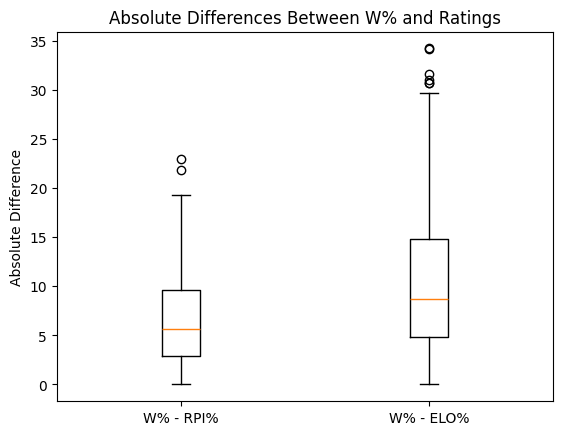

In [247]:
# Extract data for boxplots
wp_diff_rpi_values = [diffs['W% - RPI%'] for diffs in differences.values()]
wp_diff_elo_values = [diffs['W% - ELO%'] for diffs in differences.values()]

# Create boxplots
plt.boxplot([wp_diff_rpi_values, wp_diff_elo_values], labels=['W% - RPI%', 'W% - ELO%'])
plt.title('Absolute Differences Between W% and Ratings')
plt.ylabel('Absolute Difference')
plt.show()